In [48]:
import os, sys, time, resource, re, gc, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from collections import Counter


import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import csv


import django

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from utils.text import *
from utils.utils import *

from parliament.models import *
from tmv_app.models import *

sid = 13

In [2]:
sent_link = "http://pcai056.informatik.uni-leipzig.de/downloads/etc/SentiWS/SentiWS_v1.8c.zip"
sent_path = "SentiWS/SentiWS_v1.8c_Negative.txt"

s = Search.objects.get(pk=sid)
pars = Paragraph.objects.filter(search_matches=s)

pars = Paragraph.objects.filter(text__isnull=False,text__iregex='\w')

if not os.path.exists(sent_path):
    print("fetching data from sentiws")
    url = urlopen(sent_link)
    zipfile = ZipFile(BytesIO(url.read()))
    zipfile.extractall("SentiWS")
    print(zipfile.namelist())

In [3]:
from utils.text import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stat = RunStats.objects.filter(psearch=s).last()

abstracts, docsizes, ids = proc_texts(pars, stoplist, stat.fulltext)
doc_ids = ids

vectorizer = CountVectorizer(
    max_df=stat.max_df,
    min_df=5,
    max_features=100000,
    ngram_range=(stat.ngram,stat.ngram),
    #tokenizer=german_stemmer(),
    stop_words=set(nltk.corpus.stopwords.words("german"))
)
dtf = vectorizer.fit_transform(abstracts)
dtf

<370208x87662 sparse matrix of type '<class 'numpy.int64'>'
	with 13462193 stored elements in Compressed Sparse Row format>

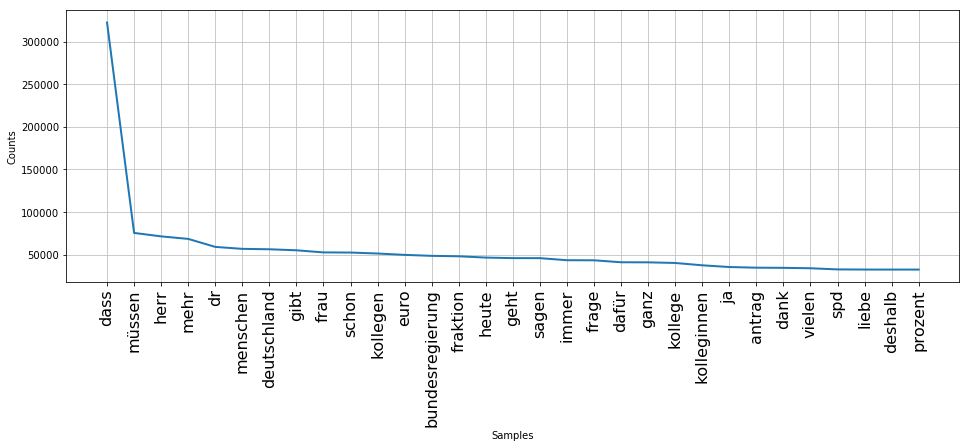

In [4]:
vocab = list(vectorizer.get_feature_names())
counts = dtf.sum(axis=0).A1
freq_dist = nltk.FreqDist(flatten([[x[0]]*x[1] for x in zip(vocab,counts)]))

plt.figure(figsize=(16,5))
plt.xticks(size=16)
freq_dist.plot(31)

In [5]:
import_words = False

if import_words:
    poswords = csv.reader(open('SentiWS/SentiWS_v1.8c_Positive.txt', 'r'), delimiter='\t')
    negwords = csv.reader(open('SentiWS/SentiWS_v1.8c_Negative.txt', 'r'), delimiter='\t')
    for i,row in enumerate(poswords):
        if len(row) > 2:
            ts = [row[0].split('|')[0]]+row[2].split(',')
        else:
            ts = [row[0].split('|')[0]]
        for t in ts:
            term, created = Term.objects.get_or_create(title=t.strip())
            tp, created = TermPolarity.objects.get_or_create(term=term,source="SentiWS")
            tp.polarity = float(row[1])
            tp.POS = row[0].split('|')[1].strip()
            tp.save()

    for i,row in enumerate(negwords):
        if len(row) > 2:
            ts = [row[0].split('|')[0]]+row[2].split(',')
        else:
            ts = [row[0].split('|')[0]]
        for t in ts:
            term, created = Term.objects.get_or_create(title=t.strip())
            tp, created = TermPolarity.objects.get_or_create(term=term,source="SentiWS")
            tp.polarity = float(row[1])
            tp.POS = row[0].split('|')[1].strip()
            tp.save()

In [6]:
pols = []
for v in vocab:
    try:
        p = TermPolarity.objects.get(term__title=v)
        pols.append(p.polarity)
    except:
        pols.append(0)
    

In [7]:
sentiment_scores = dtf*pols


In [8]:
sentiment_scores

array([ 0.9337,  1.0032,  0.8441, ...,  0.933 ,  0.008 , -0.2184])

In [9]:
Document.objects.filter(date__isnull=True)

<QuerySet [<Document: None - plenarprotokolle , 17>]>

In [10]:
df = pd.DataFrame.from_dict({
    'text':abstracts,
    'sentiment': sentiment_scores,
    'party': [p.utterance.speaker.party.name if p.utterance.speaker.party is not None else None for p in pars],
    'colour': [p.utterance.speaker.party.colour if p.utterance.speaker.party is not None else None for p in pars],
    'date': [p.utterance.document.date for p in pars],
    'month': [p.utterance.document.date.month if p.utterance.document.date is not None else None for p in pars ]
})

df.head()



,colour,date,month,party,sentiment,text
0,#FFED00,2012-06-15,6.0,fdp,0.9337,"Guten Morgen, liebe Kolleginnen und Kollegen! ..."
1,#000000,2012-06-15,6.0,cducsu,1.0032,Herr Präsident! Meine sehr verehrten Damen und...
2,#000000,2012-06-15,6.0,cducsu,0.8441,Es geht um drei Bereiche:\n\nErstens haben sic...
3,#000000,2012-06-15,6.0,cducsu,0.6942,"Der zweite Bereich, in dem sich die Märkte aus..."
4,#000000,2012-06-15,6.0,cducsu,0.7472,Der dritte Bereich ist das Gesundheitswesen. E...


In [23]:
df['text_length'] = df['text'].str.len() 
df['scaled_sentiment'] = df['sentiment'] / df['text_length']
df.sort_values('scaled_sentiment').head()

,colour,date,month,party,sentiment,text,scaled_sentiment,text_length
80761,#EB001F,2015-01-14,1.0,spd,-0.7618,Falsch!,-0.108829,7
132125,#64A12D,2012-12-13,12.0,gruene,-0.8930,Schämen Sie sich!,-0.052529,17
286411,#EB001F,2015-01-29,1.0,spd,-0.8350,schlicht absurd.,-0.052187,16
41149,#000000,2012-09-13,9.0,cducsu,-0.7618,Das ist falsch.,-0.050787,15
172458,#8C3473,2015-02-05,2.0,linke,-0.7618,Das ist falsch.,-0.050787,15


In [40]:
min_length = 50
filt_df = df[(df['text_length'] > min_length) & (df['text'].str.contains("kohle",case=False))]
for i,p in filt_df.sort_values('scaled_sentiment').head().iterrows():
    print('\n#########')
    print(p['sentiment'])
    print(p['party'])
    print(p['text'])


#########
-1.1322
afd
Bloß nicht den brüchigen Frieden mit der profitmaximierenden FDP brechen! Dafür opfert man ja nicht nur die Kohlekraftwerke,

#########
-0.7706
fdp
Wenn Sie das schlecht finden, dann sind Sie die Befürworter von mehr Kohle, von mehr Gas und von weniger Klimaschutz, meine Damen und Herren von den Grünen.

#########
-2.7908999999999997
gruene
Die Kohle- und Atomkonzerne können sich momentan wirklich nicht über die Entscheidungen der Bundesregierung beklagen. Eine schlecht gemachte Brennelementesteuer ist gerade von den Gerichten kassiert worden. Das kostet uns 6,3 Milliarden Euro plus Zinsen in Höhe von 6 Prozent. - Wo kriegt man eigentlich 6 Prozent Zinsen? Hat der Finanzminister so viel Geld, dass er 6 Prozent Zinsen zahlen kann? - Das hat die Aktienkurse der Atomkonzerne hochschnellen lassen. Das geht in eine falsche Richtung, weil es die falschen Strukturen zementiert. Damit muss wirklich Schluss sein.

#########
-1.2567
linke
Wer bekommt nun diese Subventionen

In [41]:
for i,p in filt_df.sort_values('scaled_sentiment').tail().iterrows():
    print('\n#########')
    print(p['sentiment'])
    print(p['party'])
    print(p['text'])


#########
1.6899
linke
Halten wir fest: Die Hetze gegen erneuerbare Energien nützt wem? Der Atom- und Kohlelobby und den großen Stromkonzernen. Sie nützt aber mitnichten den Menschen, die von Stromsperren betroffen sind. Alles in allem ist diese Debatte über steigende Strompreise und erneuerbare Energien ein wunderbares Lehrstück; denn hieran lässt sich ganz hervorragend beobachten, wie die Herrschenden den Eindruck erwecken,

#########
2.3071
linke
Es ist ja wohl das Mindeste, dass man sich mit diesem Thema beschäftigt.

Ich will ganz grundsätzlich sagen, was man an diesem Thema wunderbar zeigen kann: Immer wenn sich der Staat zurückzieht - die Menschen erleben den Staat logischerweise in der Kommune; wo denn sonst? -, sind diejenigen fein raus, denen es gut geht und die ordentlich Kohle haben. Wer einen Privatlehrer hat, kann Unterrichtsausfall natürlich wunderbar kompensieren. Wer viel Geld hat und viele Bücher kaufen kann, der braucht natürlich auch keine öffentliche Bibliothek.



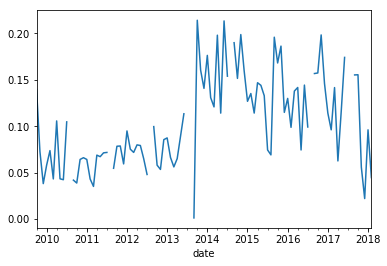

In [14]:

months = df.set_index(pd.to_datetime(df['date']))
months.groupby(pd.Grouper(freq='M'))['sentiment'].mean().plot()

plt.show()

afd
cducsu
gruene
linke
spd


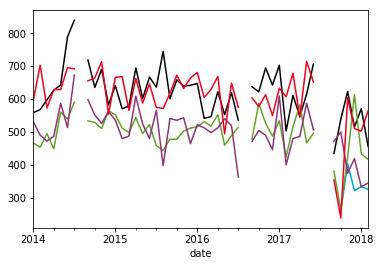

In [44]:
for name, group in months[months['date']>datetime.date(2014,1,1)].groupby(['party']):
    if name in ["cducsu","linke","spd","afd","gruene"]:     
        print(name)
        group.groupby(pd.Grouper(freq='M'))['scaled_sentiment'].mean().plot(color=group['colour'][0])
        #group['month'] = group['date'].month
        #group.groupby(['date'])['sentiment'].mean().plot()

#df.groupby(['date','party'])['sentiment'].mean().plot()

plt.show()

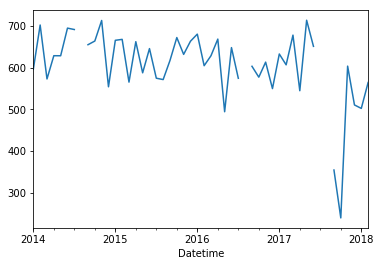

In [45]:
group['Datetime'] = pd.to_datetime(group['date'])
group = group.set_index(group['Datetime'])
#group = group.set_index(pd.DatetimeIndex(group['Datetime']))

group
group.groupby(pd.Grouper(freq='M'))['scaled_sentiment'].mean().plot()

plt.show()

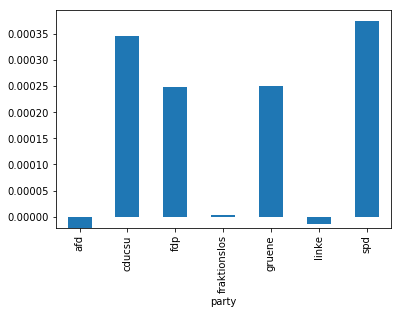

In [46]:
df.groupby('party')['scaled_sentiment'].mean().plot(kind='bar')

plt.show()

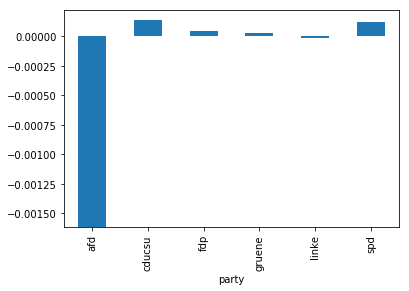

In [47]:
filt_df.groupby('party')['scaled_sentiment'].mean().plot(kind='bar')
plt.show()